In [14]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

In [15]:
from aeon.datasets import load_classification

X, y = load_classification("ECG200")

y = np.where(y == '-1', 0, y)
y = y.astype(np.float64)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1234)

## Model Training

### Simple LSTM

In [16]:
import tensorflow as tf
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout

def create_lstm_model(sequence_length, n_features):
    model = Sequential([
        LSTM(32, input_shape=(sequence_length, n_features), return_sequences=True),
        Dropout(0.2),
        LSTM(16),
        Dropout(0.2),
        Dense(8, activation='relu'),
        Dense(1, activation='sigmoid')
    ])

    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=['accuracy']
    )

    return model

In [17]:
sequence_length = 1
n_features = 96

lstm = create_lstm_model(sequence_length, n_features)

# Training
lstm.fit(X_train, y_train, epochs=30, batch_size=8, validation_split=0.2)

Epoch 1/30
16/16 [==============================] - 7s 111ms/step - loss: 0.6676 - accuracy: 0.6484 - val_loss: 0.6652 - val_accuracy: 0.5312
Epoch 2/30
16/16 [==============================] - 0s 7ms/step - loss: 0.6065 - accuracy: 0.7109 - val_loss: 0.6336 - val_accuracy: 0.5625
Epoch 3/30
16/16 [==============================] - 0s 8ms/step - loss: 0.5441 - accuracy: 0.7656 - val_loss: 0.6041 - val_accuracy: 0.6562
Epoch 4/30
16/16 [==============================] - 0s 8ms/step - loss: 0.4784 - accuracy: 0.8359 - val_loss: 0.5809 - val_accuracy: 0.7188
Epoch 5/30
16/16 [==============================] - 0s 8ms/step - loss: 0.4348 - accuracy: 0.8516 - val_loss: 0.5437 - val_accuracy: 0.7812
Epoch 6/30
16/16 [==============================] - 0s 8ms/step - loss: 0.3889 - accuracy: 0.8672 - val_loss: 0.5798 - val_accuracy: 0.7500
Epoch 7/30
16/16 [==============================] - 0s 7ms/step - loss: 0.3572 - accuracy: 0.8906 - val_loss: 0.5918 - val_accuracy: 0.7812
Epoch 8/30
16/16 [

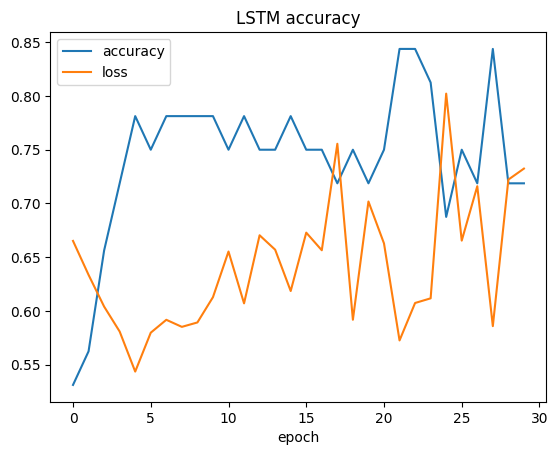

In [18]:
# plot val_accuracy and val_loss per epoch
history = lstm.history.history

plt.plot(history['val_accuracy'])
plt.plot(history['val_loss'])
plt.title('LSTM accuracy')
plt.xlabel('epoch')
plt.legend(['accuracy', 'loss'], loc='upper left')
plt.show()

In [19]:
LSTM_pred = lstm.predict(X_test)
bin_LSTM_pred = np.where(LSTM_pred > 0.5, 1, 0)

LSTM_accuracy = accuracy_score(y_test, bin_LSTM_pred)
print(f"Accuracy: {LSTM_accuracy}")

2/2 [==============================] - 1s 4ms/step
Accuracy: 0.85


### Catch22

In [20]:
import numpy as np
import pandas as pd
import pycatch22

def compute_catch22_features(X):
    if isinstance(X, pd.DataFrame):
        X = X.values

    # Ensure X is a 2D numpy array
    X = np.asarray(X)
    if X.ndim == 1:
        X = X.reshape(1, -1)

    # Get feature names from first valid time series
    feature_names = pycatch22.catch22_all(X[0].flatten())['names']

    # Initialize array to store all features
    all_features = np.zeros((len(X), len(feature_names)))

    # Compute features for each time series
    for i, series in enumerate(X):
        try:
            # Ensure the series is 1D
            series = series.flatten()
            features = pycatch22.catch22_all(series)['values']
            all_features[i] = features
        except Exception as e:
            print(f"Error processing series {i}: {str(e)}")
            # You might want to handle this error differently depending on your needs
            all_features[i] = np.nan

    # Create DataFrame with feature names
    df_features = pd.DataFrame(all_features, columns=feature_names)

    return df_features

catch22_X = compute_catch22_features(X)

In [21]:
catch22_X.head()

,DN_HistogramMode_5,DN_HistogramMode_10,CO_f1ecac,CO_FirstMin_ac,CO_HistogramAMI_even_2_5,CO_trev_1_num,MD_hrv_classic_pnn40,SB_BinaryStats_mean_longstretch1,SB_TransitionMatrix_3ac_sumdiagcov,PD_PeriodicityWang_th0_01,...,FC_LocalSimple_mean1_tauresrat,DN_OutlierInclude_p_001_mdrmd,DN_OutlierInclude_n_001_mdrmd,SP_Summaries_welch_rect_area_5_1,SB_BinaryStats_diff_longstretch0,SB_MotifThree_quantile_hh,SC_FluctAnal_2_rsrangefit_50_1_logi_prop_r1,SC_FluctAnal_2_dfa_50_1_2_logi_prop_r1,SP_Summaries_welch_rect_centroid,FC_LocalSimple_mean3_stderr
0,1.045195,0.839203,12.897849,36.0,0.648035,-0.000608,0.778947,45.0,0.041667,8.0,...,0.250000,-0.854167,-0.281250,0.965965,8.0,1.692256,0.800000,0.428571,0.098175,0.344165
1,0.302434,0.545679,7.978666,20.0,0.297887,0.003755,0.947368,24.0,0.040000,7.0,...,0.062500,0.072917,-0.552083,0.791941,5.0,1.820093,0.742857,0.600000,0.147262,0.662674
2,0.614779,0.805575,12.790413,34.0,0.852492,0.000112,0.747368,46.0,0.041667,0.0,...,0.250000,-0.833333,-0.281250,0.970727,7.0,1.541627,0.771429,0.428571,0.098175,0.308408
3,0.133587,0.333877,10.746980,33.0,0.734938,0.001211,0.715789,42.0,0.040000,0.0,...,0.111111,-0.010417,-0.208333,0.943879,13.0,1.411409,0.771429,0.685714,0.098175,0.324871
4,0.730631,0.458123,8.122401,26.0,0.582694,0.014157,0.831579,42.0,0.054422,4.0,...,0.153846,-0.906250,-0.416667,0.873607,7.0,1.665792,0.771429,0.200000,0.147262,0.508570


In [22]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

def getPCA(X, n_components=2):
    pca = PCA(n_components=n_components)
    X_pca = pca.fit_transform(X)
    return X_pca

def getTSNE(X, n_components=2):
    tsne = TSNE(n_components=n_components)
    X_tsne = tsne.fit_transform(X)
    return X_tsne

In [23]:
catch22_X_pca = getPCA(catch22_X, n_components=2)

plt.figure(figsize=(12, 6))
# plot compoments
sns.scatterplot(x=catch22_X_pca[:, 0], y=catch22_X_pca[:, 1], hue=y, palette='viridis', alpha=0.7)
plt.title('PCA Components', fontsize=14, pad=15)
plt.xlabel('Component 1', fontsize=12)
plt.ylabel('Component 2', fontsize=12)
plt.grid(True, alpha=0.3)
plt.legend(title='Class')
plt.show()


NameError: name 'sns' is not defined

<Figure size 1200x600 with 0 Axes>

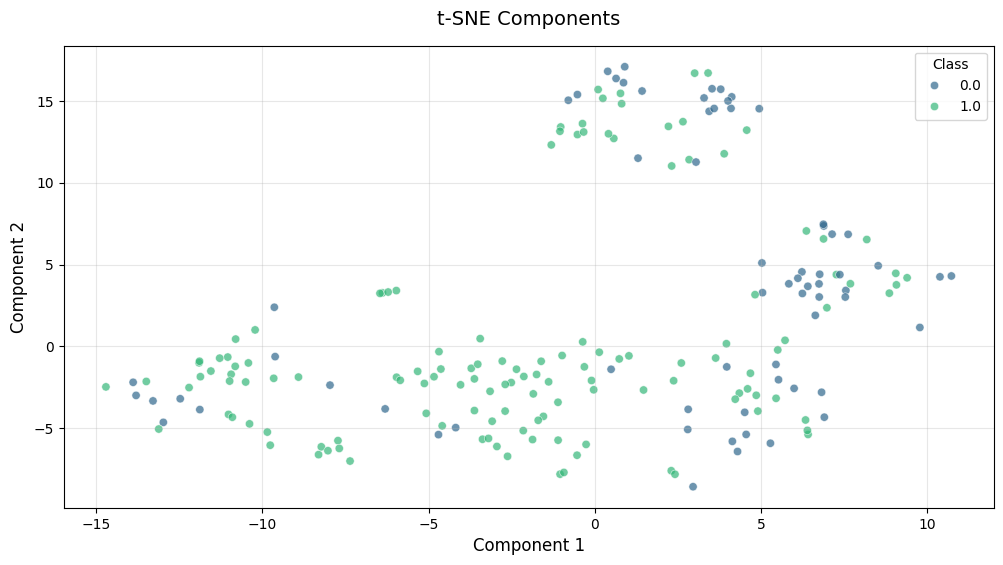

In [41]:
catch22_X_tsne = getTSNE(catch22_X, n_components=2)

plt.figure(figsize=(12, 6))
# plot compoments
sns.scatterplot(x=catch22_X_tsne[:, 0], y=catch22_X_tsne[:, 1], hue=y, palette='viridis', alpha=0.7)
plt.title('t-SNE Components', fontsize=14, pad=15)
plt.xlabel('Component 1', fontsize=12)
plt.ylabel('Component 2', fontsize=12)
plt.grid(True, alpha=0.3)
plt.legend(title='Class')
plt.show()

In [27]:
from sklearn.ensemble import RandomForestClassifier

catch22_X_train, catch22_X_test, catch22_y_train, catch22_y_test = train_test_split(catch22_X, y, test_size=0.2, random_state=1234)

clf = RandomForestClassifier(random_state=42)
clf.fit(catch22_X_train, catch22_y_train)

catch22_pred = clf.predict(catch22_X_test)

catch22_accuracy = accuracy_score(catch22_y_test, catch22_pred)
print(f"Accuracy: {catch22_accuracy}")

Accuracy: 0.85


### ROCKET

In [28]:
import numpy as np
from rocket.code.rocket_functions import generate_kernels, apply_kernels
from sklearn.linear_model import RidgeClassifierCV

# reshape the input data by removing the middle dimension if it exists
X_train = np.squeeze(X_train, axis=1) if len(X_train.shape) == 3 and X_train.shape[1] == 1 else X_train
X_test = np.squeeze(X_test, axis=1) if len(X_test.shape) == 3 and X_test.shape[1] == 1 else X_test

# Generate random kernels
kernels = generate_kernels(X_train.shape[-1], 10_000)

# Transform training set and train classifier
X_train_transform = apply_kernels(X_train, kernels)
print(X_train_transform.shape)

# Train the classifier
rocket = RidgeClassifierCV(alphas=np.logspace(-3, 3, 10))
rocket.fit(X_train_transform, y_train)

(160, 20000)


RidgeClassifierCV(alphas=array([1.00000000e-03, 4.64158883e-03, 2.15443469e-02, 1.00000000e-01,
       4.64158883e-01, 2.15443469e+00, 1.00000000e+01, 4.64158883e+01,
       2.15443469e+02, 1.00000000e+03]))

In [31]:
# Transform test set and predict
X_test_transform = apply_kernels(X_test, kernels)
rocket_pred = rocket.predict(X_test_transform)

rocket_accuracy = accuracy_score(y_test, rocket_pred)
print(f"Accuracy: {rocket_accuracy}")

Accuracy: 0.925


## Borderline Examples with DTW Distance

### Sample Wise Bordeline Examples

In [32]:
from aeon.distances import dtw_distance

def get_DTW_distance(X: pd.DataFrame) -> np.ndarray:
    distances = np.zeros((X.shape[0], X.shape[0]))

    # get distance matrix
    for i in range(X.shape[0]):
        for j in range(i + 1, X.shape[0]):
            distance = dtw_distance(X[i], X[j])
            distances[i, j] = distance
            distances[j, i] = distance

    # get the indices of the 5 closest points
    closer_neighbors = np.argsort(distances, axis=1)[:, 1:6]
    return closer_neighbors


def get_Borderline_Binary(closer_neighbors: np.ndarray, y: np.ndarray) -> dict:
    borderline_pairs = {}

    for i in range(len(closer_neighbors)):
        own_class = [n for n in closer_neighbors[i] if y[i] == y[n]]
        other_class = [n for n in closer_neighbors[i] if y[i] != y[n]]

        if abs(len(own_class) - len(other_class)) == 1:
            borderline_pairs[i] = other_class

    return borderline_pairs

In [33]:
closer_N = get_DTW_distance(X_test)
borderline_pairs = get_Borderline_Binary(closer_N, y_test)

print(borderline_pairs)

{8: [16, 1, 30], 10: [36, 19], 12: [16, 1, 30], 16: [29, 8, 12], 20: [30, 7], 25: [19, 36], 28: [19, 36], 30: [29, 20], 36: [10, 8, 12]}


### Global Borderline Examples

In [16]:
def get_DTWGlobalBorderline(X, y, n_samples):   
    # check if y in binarry 
    if np.unique(y).shape[0] != 2:
        print("Error: Target must be binary")

    class0_X = X[y == 0]
    class1_X = X[y == 1]

    distances = []
    indices = []

    # get distance matrix
    for i, sample0 in enumerate(class0_X):
        for j, sample1 in enumerate(class1_X):
            distances.append(dtw_distance(sample0, sample1))
            indices.append((i,j))


    distances = np.array(distances)
    closer_neighbors = np.argsort(distances)[:n_samples]

    borderline_neig = [(indices[idx], distances[idx]) for idx in closer_neighbors]
    return borderline_neig, (class0_X, class1_X)

In [17]:
borderline, classes = get_DTWGlobalBorderline(X, y, 20)

borderline

[((39, 57), 0.9883526525438192),
 ((41, 78), 1.0279668929868109),
 ((60, 127), 1.1208234716838588),
 ((44, 127), 1.1754179385352703),
 ((30, 118), 1.1892715146566044),
 ((7, 57), 1.2398384525734059),
 ((1, 57), 1.2860888725731052),
 ((65, 127), 1.294911066362742),
 ((11, 57), 1.3821888807348568),
 ((32, 127), 1.3876578891928233),
 ((39, 6), 1.3951505954979075),
 ((41, 29), 1.4083973160591405),
 ((5, 29), 1.4357188490053379),
 ((7, 29), 1.4442282800567483),
 ((59, 6), 1.4525140898547715),
 ((11, 6), 1.4546219987046676),
 ((39, 78), 1.4554695759675624),
 ((11, 29), 1.4879766776385095),
 ((48, 78), 1.4937489031039195),
 ((32, 29), 1.516008640888832)]

## Morphing and Sensitivity

### Per Instance Analysis


In [34]:
import numpy as np
import tensorflow as tf
import importlib
tsmorph = importlib.import_module('tsmorph-xai.tsmorph.tsmorph')
TSmorph = tsmorph.TSmorph


def Binay_MorphingCalculater(X_morph, y_morph, borderline_pairs, model, granularity=20, rocket_kernels=None, catch22_features=False):
    pairs = []
    # create list of tuples (key, element[i])
    for key in borderline_pairs:
        for i in range(len(borderline_pairs[key])):
            pairs.append([key, borderline_pairs[key][i]])

    print(pairs)
    morphs = []
    results = {}
    metrics = {}

    for sample in pairs:
        # desired shape (1, 96)
        source_ts = X_morph[sample[0]].reshape(1,-1)
        target_ts = X_morph[sample[1]].reshape(1,-1)
        #print(source_ts.shape)

        # apply morphing
        morphing = TSmorph(S=source_ts, T=target_ts, granularity=granularity+2).transform()
        morphing = morphing.T

        # Predict new labels using selected model
        if isinstance(model, tf.keras.Model):
            morphing = morphing.to_numpy()
            if len(morphing.shape) != 3:  # Ensure it has 3 dimensions (samples, sequence_length, features)
                morphing = morphing.reshape(morphing.shape[0], 1, morphing.shape[1])
    
            print(morphing.shape)
            pred = model.predict(morphing)
            pred = np.where(pred > 0.5, 1, 0)

        elif catch22_features:
            features = compute_catch22_features(morphing)
            print(morphing.shape)
            pred = model.predict(features)

        elif rocket_kernels is not None:  # Fixed variable name from kernels to rocket_kernels
            morphing = np.array(morphing, dtype=np.float64)
            print(morphing.shape)
            morphing_transform = apply_kernels(morphing, rocket_kernels)
            pred = model.predict(morphing_transform)

        # check if model predictions align with ground truth
        if (y_morph[sample[0]] == pred[0] and y_morph[sample[1]] == pred[-1]):
            # calculate morphing percentage
            change_idx = 1
            for i in range(1, len(pred)-1):  # account for both original series
                if pred[0] != pred[i]:
                    change_idx = i
                    break
            morph_perc = 1/granularity * change_idx
            morphs.append(morph_perc)

            results[(sample[0], sample[1])] = round(morph_perc, 2)
        else:
            continue

    # Calculate metrics only if morphs list is not empty
    if morphs:
        metrics['mean'] = float(np.mean(morphs))
        metrics['std'] = float(np.std(morphs))
    else:
        metrics['mean'] = 0.0
        metrics['std'] = 0.0

    return results, metrics

In [35]:
res = Binay_MorphingCalculater(X_test, y_test, borderline_pairs, model=lstm)
res

[[8, 16], [8, 1], [8, 30], [10, 36], [10, 19], [12, 16], [12, 1], [12, 30], [16, 29], [16, 8], [16, 12], [20, 30], [20, 7], [25, 19], [25, 36], [28, 19], [28, 36], [30, 29], [30, 20], [36, 10], [36, 8], [36, 12]]
(22, 1, 96)
1/1 [==============================] - 0s 35ms/step
(22, 1, 96)
1/1 [==============================] - 0s 42ms/step
(22, 1, 96)
1/1 [==============================] - 0s 38ms/step
(22, 1, 96)
1/1 [==============================] - 0s 35ms/step
(22, 1, 96)
1/1 [==============================] - 0s 36ms/step
(22, 1, 96)
1/1 [==============================] - 0s 38ms/step
(22, 1, 96)
1/1 [==============================] - 0s 33ms/step
(22, 1, 96)
1/1 [==============================] - 0s 36ms/step
(22, 1, 96)
1/1 [==============================] - 0s 35ms/step
(22, 1, 96)
1/1 [==============================] - 0s 34ms/step
(22, 1, 96)
1/1 [==============================] - 0s 37ms/step
(22, 1, 96)
1/1 [==============================] - 0s 39ms/step
(22, 1, 96)
1/1 [==

({(8, 1): 0.25, (8, 30): 0.25, (20, 30): 0.25, (30, 29): 0.4, (30, 20): 0.85},
 {'mean': 0.4, 'std': 0.23237900077244505})

In [36]:
res = Binay_MorphingCalculater(X_test, y_test, borderline_pairs, model=clf, catch22_features=True)
res

[[8, 16], [8, 1], [8, 30], [10, 36], [10, 19], [12, 16], [12, 1], [12, 30], [16, 29], [16, 8], [16, 12], [20, 30], [20, 7], [25, 19], [25, 36], [28, 19], [28, 36], [30, 29], [30, 20], [36, 10], [36, 8], [36, 12]]
(22, 96)
(22, 96)
(22, 96)
(22, 96)
(22, 96)
(22, 96)
(22, 96)
(22, 96)
(22, 96)
(22, 96)
(22, 96)
(22, 96)
(22, 96)
(22, 96)
(22, 96)
(22, 96)
(22, 96)
(22, 96)
(22, 96)
(22, 96)
(22, 96)
(22, 96)


({(20, 30): 0.05,
  (25, 19): 0.4,
  (25, 36): 0.4,
  (28, 19): 0.85,
  (28, 36): 0.65,
  (30, 20): 0.05},
 {'mean': 0.39999999999999997, 'std': 0.29154759474226505})

In [37]:
res = Binay_MorphingCalculater(X_test, y_test, borderline_pairs, model=rocket, rocket_kernels=kernels)
res

[[8, 16], [8, 1], [8, 30], [10, 36], [10, 19], [12, 16], [12, 1], [12, 30], [16, 29], [16, 8], [16, 12], [20, 30], [20, 7], [25, 19], [25, 36], [28, 19], [28, 36], [30, 29], [30, 20], [36, 10], [36, 8], [36, 12]]
(22, 96)
(22, 96)
(22, 96)
(22, 96)
(22, 96)
(22, 96)
(22, 96)
(22, 96)
(22, 96)
(22, 96)
(22, 96)
(22, 96)
(22, 96)
(22, 96)
(22, 96)
(22, 96)
(22, 96)
(22, 96)
(22, 96)
(22, 96)
(22, 96)
(22, 96)


({(8, 16): 0.4,
  (8, 1): 0.3,
  (8, 30): 0.35,
  (10, 36): 0.45,
  (10, 19): 0.15,
  (16, 8): 0.7,
  (20, 30): 0.35,
  (20, 7): 0.45,
  (25, 19): 0.55,
  (25, 36): 0.25,
  (28, 19): 1.0,
  (28, 36): 0.6,
  (30, 20): 0.75,
  (36, 10): 0.65,
  (36, 8): 0.35},
 {'mean': 0.4866666666666667, 'std': 0.21483844059096022})

### Class Based Analysis

In [24]:
from aeon.datasets import load_classification

X, y = load_classification("ECG200")

y = np.where(y == '-1', 0, y)
y = y.astype(np.float64)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1234)

In [25]:
import numpy as np
import seaborn as sns
import pandas as pd
import tensorflow as tf
import importlib
tsmorph = importlib.import_module('tsmorph-xai.tsmorph.tsmorph')
TSmorph = tsmorph.TSmorph
from DBA import performDBA

def getDBA(X_morph, y_morph, plot=False):
    # seprate y_morph per target class
    if np.unique(y_morph).shape[0] != 2:
        print("Error: Target class should be binary")
        
    X_morph_0 = X_morph[y_morph == 0].squeeze(axis=1)
    X_morph_1 = X_morph[y_morph == 1].squeeze(axis=1)

    avg_class0 = performDBA(X_morph_0)
    avg_class1 = performDBA(X_morph_1)

    centers = np.array([avg_class0, avg_class1])

    if plot:
        plt.figure(figsize=(12, 6))

        for s0 in X_morph_0:
            plt.plot(s0, color='lightblue', alpha=0.3, linewidth=1, label='_')  
        for s1 in X_morph_1:
            plt.plot(s1, color='salmon', alpha=0.3, linewidth=1, label='_')
        plt.plot(avg_class0.flatten(), color='navy', linewidth=2, label='Class 0 Average')
        plt.plot(avg_class1.flatten(), color='darkred', linewidth=2, label='Class 1 Average')

        # Add labels and title
        plt.xlabel('Time Steps', fontsize=12)
        plt.ylabel('Value', fontsize=12)
        plt.title('Time Series by Class with DBA Averages', fontsize=14, pad=15)
        # Add grid and legend
        plt.grid(True, linestyle='--', alpha=0.7)
        plt.legend(fontsize=10)
        # Adjust layout
        plt.tight_layout()
        plt.show()

    return centers


def BinaryClass_MorphingCalculater(centers, model, granularity=20, rocket_kernels=None, catch22_features=False, morph_plot=False):
    if centers.shape[0] != 3:
        centers = np.expand_dims(centers, axis=1)
    
    # apply morphing
    morphing = TSmorph(S=centers[0], T=centers[1], granularity=granularity+2).transform()
    morphing = morphing.T

    results = {}
    # Predict new labels using selected model
    if isinstance(model, tf.keras.Model):
        morphing = morphing.to_numpy()
        if len(morphing.shape) != 3:  # Ensure it has 3 dimensions (samples, sequence_length, features)
            morphing = morphing.reshape(morphing.shape[0], 1, morphing.shape[1])

        #print(morphing.shape)
        pred = model.predict(morphing)
        pred = np.where(pred > 0.5, 1, 0).flatten()

    elif catch22_features:
        features = compute_catch22_features(morphing)
        pred = model.predict(features)

    elif rocket_kernels is not None:  # Fixed variable name from kernels to rocket_kernels
        morphing = np.array(morphing, dtype=np.float64)
        morphing_transform = apply_kernels(morphing, rocket_kernels)
        pred = model.predict(morphing_transform)

    pred = pred.astype(int)
    print(pred)
    # check if model predictions align with ground truth
    if (pred[0]==0 and pred[-1]==1):

        # calculate morphing percentage
        change_idx = 1
        for i in range(1, len(pred)-1):  # account for both original series
            if pred[0] != pred[i]:
                change_idx = i
                break
        morph_perc = 1/granularity * change_idx

        results[(0, 1)] = round(morph_perc, 2)

        if morph_plot:
            plt.figure(figsize=(12, 6))
            colors = ['#61E6AA', '#5722B1']
            # Plot each series with its corresponding color
            for idx, column in enumerate(morphing.T.columns):
                plt.plot(morphing.T.index, morphing.T[column], color=colors[pred[idx]], label=column, linewidth=1)

            # Customize the plot
            plt.title('Morphed Time Series with Predicted Labels', fontsize=14, pad=15)
            plt.xlabel('Time', fontsize=12)
            plt.ylabel('Value', fontsize=12)
            plt.grid(True, alpha=0.3)
            plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

            # Adjust layout to prevent label cutoff
            plt.tight_layout()
            plt.show()
            
    else:
        print(f"Model_pred={pred[0], pred[-1]}, Expected_pred={0, 1}")
        return "Error: Model prediction is not aligned with ground truth"

    return results

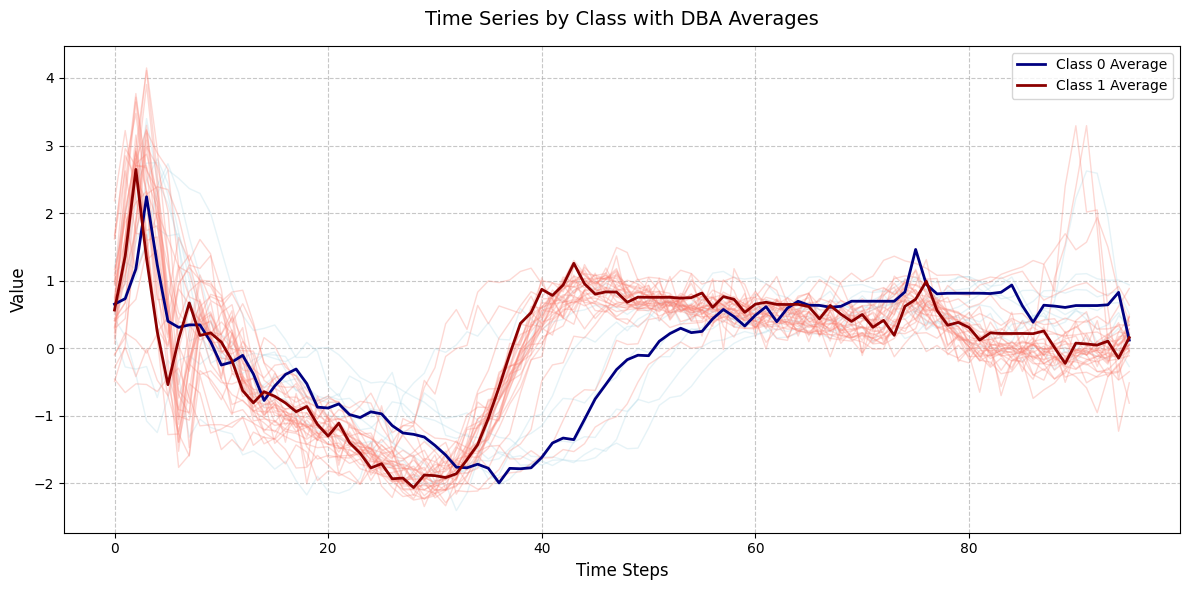

In [26]:
center = getDBA(X_test, y_test, plot=True)

In [27]:
print(center.shape)

res = BinaryClass_MorphingCalculater(center, model=lstm, morph_plot=True)
print(res)

(2, 96)
1/1 [==============================] - 0s 42ms/step
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Model_pred=(1, 1), Expected_pred=(0, 1)
Error: Model prediction is not aligned with ground truth


[0 0 1 1 1 1 1 1 1 1 0 0 0 1 1 1 1 1 1 1 1 1]


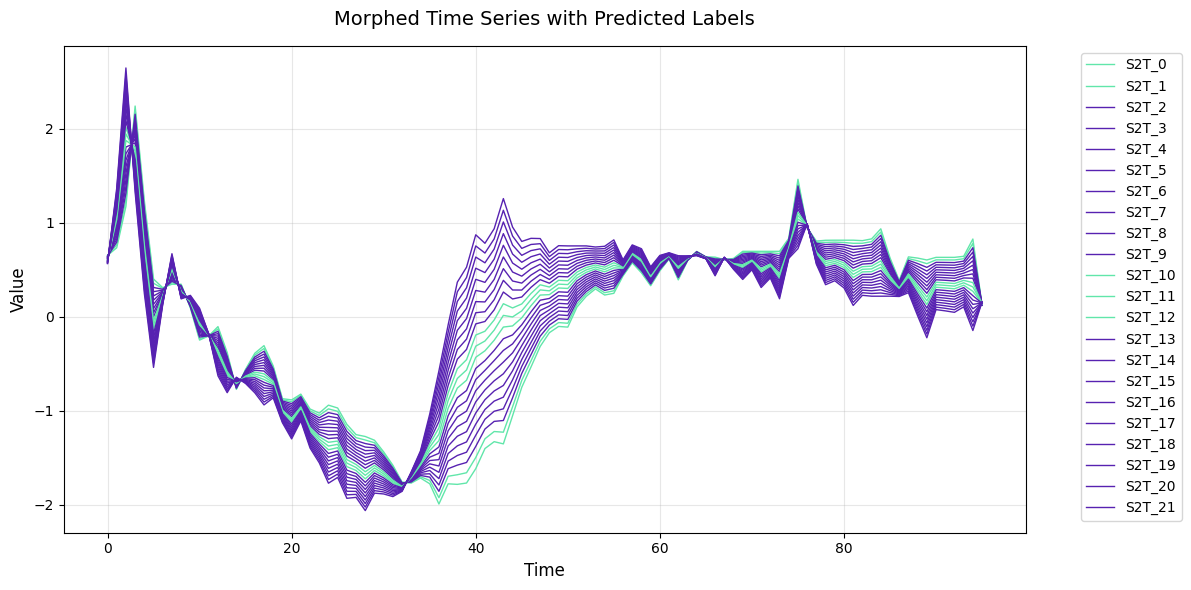

{(0, 1): 0.1}


In [28]:
res = BinaryClass_MorphingCalculater(center, model=clf, catch22_features=True, morph_plot=True)
print(res)

In [29]:
res = BinaryClass_MorphingCalculater(center, model=rocket, rocket_kernels=kernels, morph_plot=True)
print(res)

[1 1 1 1 1 1 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1]
Model_pred=(1, 1), Expected_pred=(0, 1)
Error: Model prediction is not aligned with ground truth


## Component Analysis

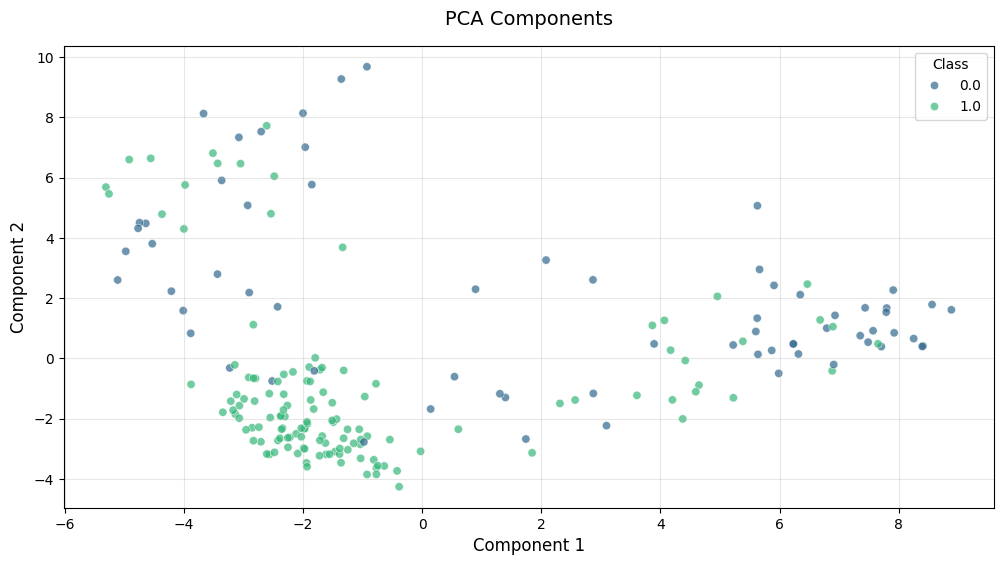

In [30]:
from sklearn.decomposition import PCA

def getPCA(X, n_components=2):
    pca = PCA(n_components=n_components)
    X_pca = pca.fit_transform(X)
    return X_pca

X_pca = getPCA(X.squeeze(axis=1), n_components=2)


plt.figure(figsize=(12, 6))
# plot compoments
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=y, palette='viridis', alpha=0.7)
plt.title('PCA Components', fontsize=14, pad=15)
plt.xlabel('Component 1', fontsize=12)
plt.ylabel('Component 2', fontsize=12)
plt.grid(True, alpha=0.3)
plt.legend(title='Class')
plt.show()

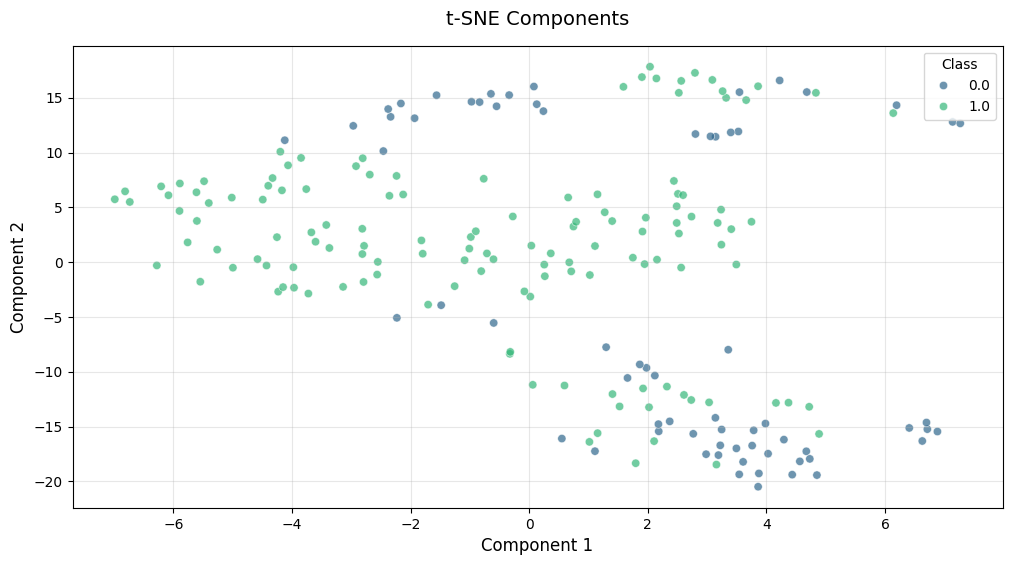

In [31]:
from sklearn.manifold import TSNE

def getTSNE(X, n_components=2):
    tsne = TSNE(n_components=n_components)
    X_tsne = tsne.fit_transform(X)
    return X_tsne

X_tsne = getTSNE(X.squeeze(axis=1), n_components=2)

plt.figure(figsize=(12, 6))
# plot compoments
sns.scatterplot(x=X_tsne[:, 0], y=X_tsne[:, 1], hue=y, palette='viridis', alpha=0.7)
plt.title('t-SNE Components', fontsize=14, pad=15)
plt.xlabel('Component 1', fontsize=12)
plt.ylabel('Component 2', fontsize=12)
plt.grid(True, alpha=0.3)
plt.legend(title='Class')
plt.show()

## Synthetic Data

In [32]:
import numpy as np
import pandas as pd
from scipy import signal

def generate_timeseries_dataset(n_samples, n_timepoints, base_functions, frequencies, noise_level, shift = None, random_seed=None):
    """
    Generate synthetic time series dataset with multiple samples and random noise.
    
    Parameters:
    -----------
    n_samples : int
        Number of time series to generate
    n_timepoints : int
        Number of time points in each series
    base_functions : list
        List of base functions to use ('sin', 'cos', 'sawtooth', 'square')
    frequencies : list
        List of frequencies to use for the base functions
    noise_level : float
        Standard deviation of the Gaussian noise to add
    random_seed : int, optional
        Random seed for reproducibility
    
    Returns:
    --------
    DataFrame
        DataFrame containing the generated time series data
    """

    if random_seed is not None:
        np.random.seed(random_seed)
    
    # Generate time points
    t = np.linspace(0, 10, n_timepoints)
    
    # Initialize DataFrame
    df = pd.DataFrame()
    df['time'] = t
    
    # Generate base signals
    base_signals = {}
    for func in base_functions:
        for freq in frequencies:
            if func == 'sin':
                signal_data = np.sin(2 * np.pi * freq * t)
            elif func == 'cos':
                signal_data = np.cos(2 * np.pi * freq * t)
            elif func == 'sawtooth':
                signal_data = signal.sawtooth(2 * np.pi * freq * t)
            elif func == 'square':
                signal_data = signal.square(2 * np.pi * freq * t)
            
            base_signals[f'{func}_{freq}'] = signal_data
    
    # Generate samples with random combinations and noise
    for i in range(n_samples):
        # Randomly combine base signals
        weights = np.random.uniform(-1, 1, len(base_signals))
        combined_signal = np.zeros_like(t)
        
        for (name, sig), weight in zip(base_signals.items(), weights):
            combined_signal += weight * sig
        
        # Normalize
        combined_signal = combined_signal / np.max(np.abs(combined_signal))
        
        # Add random noise
        noise = np.random.normal(0, noise_level, n_timepoints)
        if shift:
            final_signal = abs(combined_signal) + noise + shift
        else: final_signal = abs(combined_signal) + noise
        
        # Add to DataFrame
        df[f'sample_{i+1}'] = final_signal
    return df

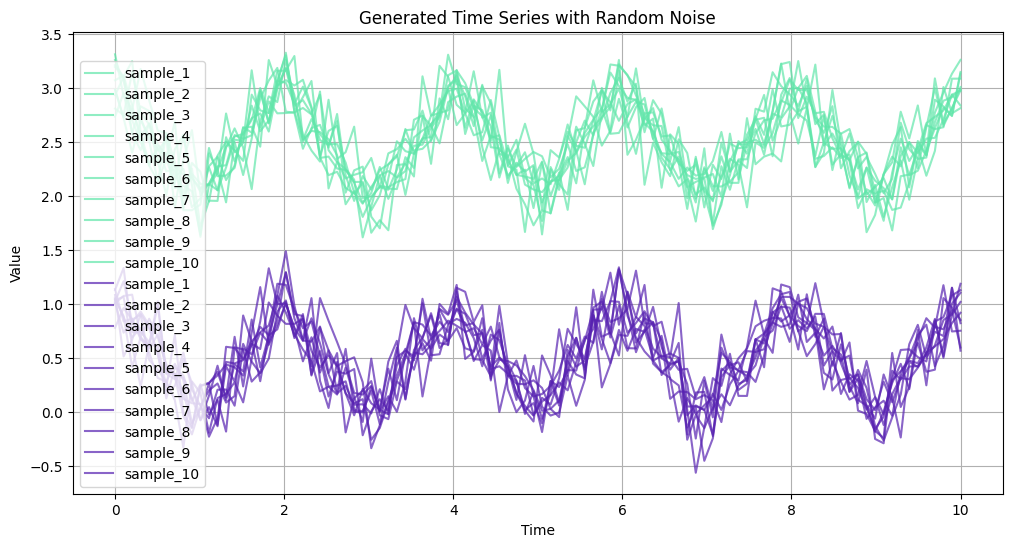

In [33]:
# Generate dataset
data1 = generate_timeseries_dataset(
    n_samples=10,
    n_timepoints=100,
    base_functions=['sawtooth'],
    frequencies=[0.5],
    noise_level=0.2,
    random_seed=123,
    shift=2
)

data2 = generate_timeseries_dataset(
    n_samples=10,
    n_timepoints=100,
    base_functions=['sawtooth'],
    frequencies=[0.5],
    noise_level=0.2,
    random_seed=42,
)


colors = ['#61E6AA', '#5722B1']
plt.figure(figsize=(12, 6))
for col in data1.columns:
    if col != 'time':
        plt.plot(data1['time'], data1[col], label=col, alpha=0.7, color=colors[0])

for col in data2.columns:
    if col != 'time':
        plt.plot(data2['time'], data2[col], label=col, alpha=0.7, color=colors[1])
    
plt.title('Generated Time Series with Random Noise')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()

In [34]:
data1 = data1.drop('time', axis=1).values
data1 = np.expand_dims(data1, axis=1)

data2 = data2.drop('time', axis=1).values
data2 = np.expand_dims(data2, axis=1)





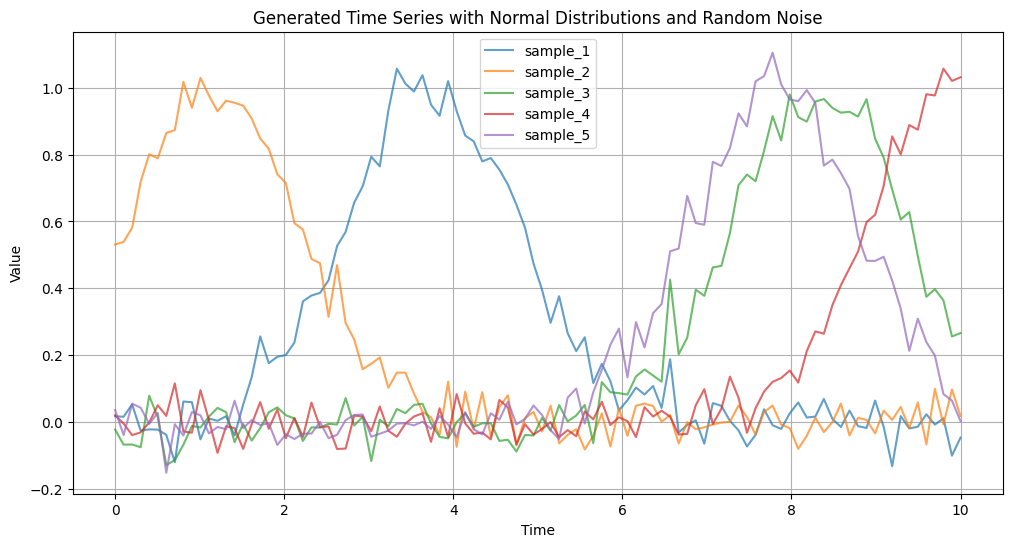

In [35]:
import numpy as np
import pandas as pd

def generate_gaussian_process(t, n_components=3, length_scales=[0.5, 1, 2], random_seed=None):
    """
    Generate a Gaussian process by summing multiple normal distributions.
    
    Parameters:
    -----------
    t : array-like
        Time points
    n_components : int
        Number of normal components to sum
    length_scales : list
        Length scales for the normal components
    random_seed : int, optional
        Random seed for reproducibility
    """
    if random_seed is not None:
        np.random.seed(random_seed)
    
    signal = np.zeros_like(t)
    
    for scale in length_scales:
        # Generate random means spread across the time range
        means = np.random.uniform(np.min(t), np.max(t), n_components)
        # Random amplitudes
        amplitudes = np.random.normal(0, 1, n_components)
        
        # Sum multiple normal distributions
        for mu, amp in zip(means, amplitudes):
            signal += amp * np.exp(-0.5 * ((t - mu) / scale) ** 2)
    
    return signal

def generate_timeseries_dataset(
    n_samples=10,
    n_timepoints=100,
    n_components=3,
    length_scales=[0.5, 1, 2],
    noise_level=0.1,
    random_seed=None
):
    """
    Generate synthetic time series dataset using normal distributions with random noise.
    
    Parameters:
    -----------
    n_samples : int
        Number of time series to generate
    n_timepoints : int
        Number of time points in each series
    n_components : int
        Number of normal components per base signal
    length_scales : list
        List of length scales for the normal distributions
    noise_level : float
        Standard deviation of the Gaussian noise to add
    random_seed : int, optional
        Random seed for reproducibility
    
    Returns:
    --------
    DataFrame
        DataFrame containing the generated time series data
    """
    if random_seed is not None:
        np.random.seed(random_seed)
    
    # Generate time points
    t = np.linspace(0, 10, n_timepoints)
    
    # Initialize DataFrame
    df = pd.DataFrame()
    df['time'] = t
    
    # Generate samples
    for i in range(n_samples):
        # Generate base signal using Gaussian process
        signal = generate_gaussian_process(
            t, 
            n_components=n_components,
            length_scales=length_scales,
            random_seed = random_seed+i if random_seed is not None else None
        )
        
        # Normalize
        signal = signal / np.max(np.abs(signal))
        
        # Add random noise
        noise = np.random.normal(0, noise_level, n_timepoints)
        final_signal = abs(signal) + noise
        
        # Add to DataFrame
        df[f'sample_{i+1}'] = final_signal
    
    return df

# Example usage
if __name__ == "__main__":
    # Generate dataset
    data = generate_timeseries_dataset(
        n_samples=5,
        n_timepoints=100,
        n_components=1,
        length_scales=[0-1],
        noise_level=0.05,
        random_seed=42
    )
    
    # Basic visualization
    import matplotlib.pyplot as plt
    
    plt.figure(figsize=(12, 6))
    for col in data.columns:
        if col != 'time':
            plt.plot(data['time'], data[col], label=col, alpha=0.7)
    
    plt.title('Generated Time Series with Normal Distributions and Random Noise')
    plt.xlabel('Time')
    plt.ylabel('Value')
    plt.legend()
    plt.grid(True)
    plt.show()

## Fancy Plotting

In [38]:
import matplotlib.pyplot as plt

def plot_gradient_timeseries(df, start_color='#61E6AA', end_color='#5722B1'):
    # Convert hex to RGB
    def hex_to_rgb(hex_color):
        hex_color = hex_color.lstrip('#')
        return tuple(int(hex_color[i:i+2], 16)/255 for i in (0, 2, 4))

    # Generate gradient colors
    start_rgb = hex_to_rgb(start_color)
    end_rgb = hex_to_rgb(end_color)
    n_series = len(df.columns)

    colors = []
    for i in range(n_series):
        ratio = i / (n_series - 1)
        r = start_rgb[0] + (end_rgb[0] - start_rgb[0]) * ratio
        g = start_rgb[1] + (end_rgb[1] - start_rgb[1]) * ratio
        b = start_rgb[2] + (end_rgb[2] - start_rgb[2]) * ratio
        colors.append((r, g, b))

    # Create the plot
    plt.figure(figsize=(12, 6))

    # Plot each series with its corresponding color
    for idx, column in enumerate(df.columns):
        plt.plot(df.index, df[column], color=colors[idx], label=column, linewidth=2)

    # Customize the plot
    plt.title('Morphed Time Series', fontsize=14, pad=15)
    plt.xlabel('Time', fontsize=12)
    plt.ylabel('Value', fontsize=12)
    plt.grid(True, alpha=0.3)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

    # Adjust layout to prevent label cutoff
    plt.tight_layout()
    plt.show()
    return

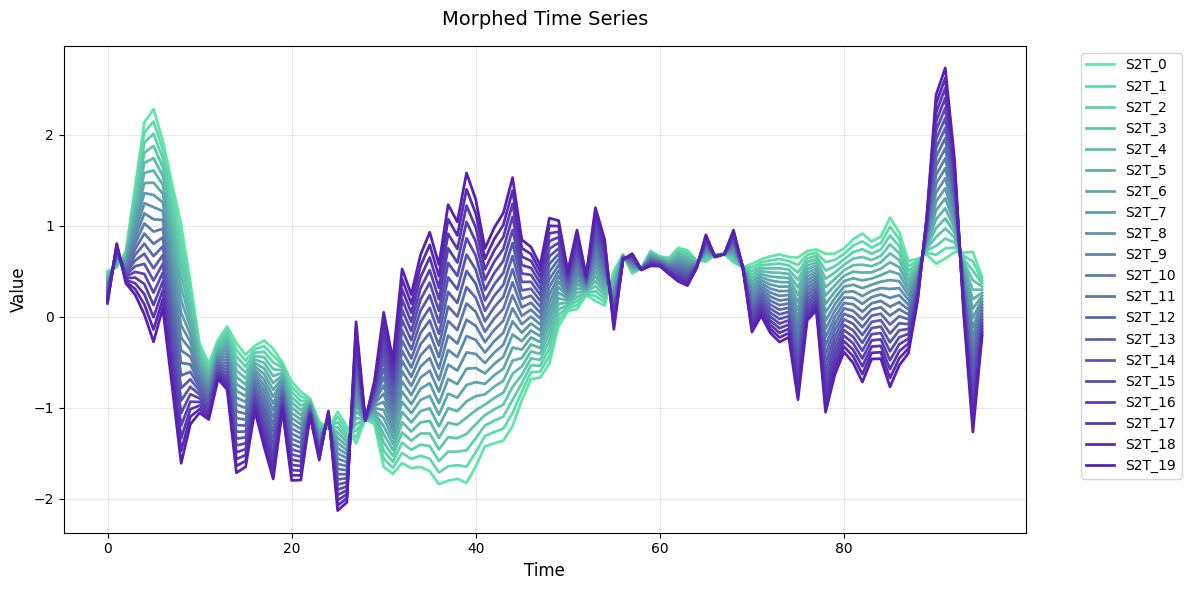

In [39]:
source_ts = X[0]
target_ts = X[1]

morphing = TSmorph(S=source_ts, T=target_ts, granularity=20).transform()

plot_gradient_timeseries(morphing)